In [1]:
import aisdb
from aisdb import DBQuery
from aisdb.database.dbconn import PostgresDBConn
from datetime import datetime, timedelta
from aisdb.discretize.h3 import Discretizer
import random
import matplotlib.pyplot as plt
import contextily as cx
import itertools
import pandas as pd
import geopandas as gpd

In [ ]:
# >>> PostgreSQL Information <<<
db_user='<>'            # DB User
db_dbname='<>'         # DB Schema
db_password='<>'    # DB Password
db_hostaddr='127.0.0.1'    # DB Host address

dbconn = PostgresDBConn(
    port=5555,             # PostgreSQL port
    user=db_user,          # PostgreSQL username
    dbname=db_dbname,      # PostgreSQL database
    host=db_hostaddr,      # PostgreSQL address
    password=db_password,  # PostgreSQL password
)

In [17]:
xmin, ymin, xmax, ymax = -70, 45, -58, 53
gulf_bbox = [xmin, xmax, ymin, ymax]
start_time = datetime(2023, 8, 1)
end_time = datetime(2023, 8, 2)

qry = DBQuery(
    dbconn=dbconn,
    start=start_time, end=end_time,
    xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
    callback=aisdb.database.sqlfcn_callbacks.in_time_bbox_validmmsi
)

ais_tracks = []
rowgen = qry.gen_qry()

In [18]:
descritizer = Discretizer(resolution=6)

# Creating discretizer object and describe based on its resolution

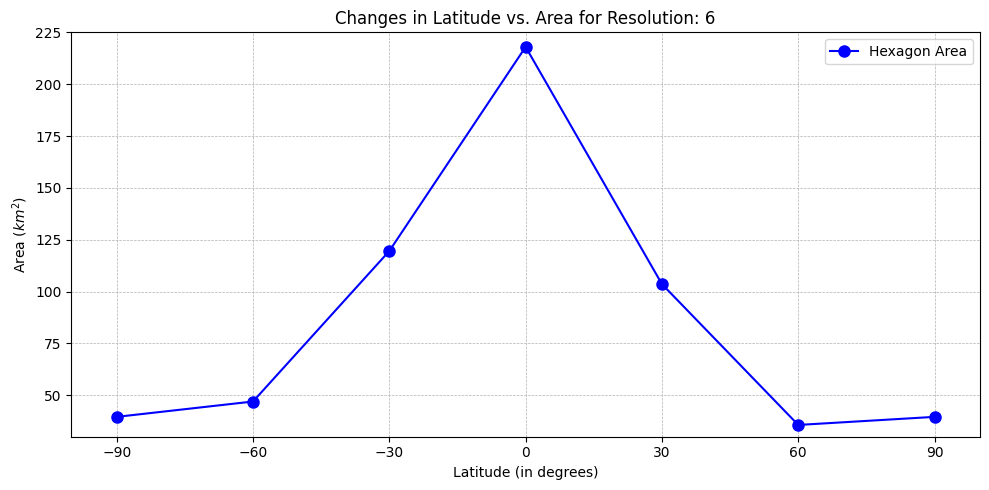


[Changes in Latitude vs. Area for Resolution: 6]
Latitude -90 (deg): Hexagon area = 39.57 (km2)
Latitude -60 (deg): Hexagon area = 46.98 (km2)
Latitude -30 (deg): Hexagon area = 119.55 (km2)
Latitude 0 (deg): Hexagon area = 217.97 (km2)
Latitude 30 (deg): Hexagon area = 103.59 (km2)
Latitude 60 (deg): Hexagon area = 35.68 (km2)
Latitude 90 (deg): Hexagon area = 39.57 (km2)

[Changes in Resolution vs. Area - [0-15]]
Resolution 0 has 1281.256011000 (km) per edge.
Resolution 1 has 483.056839100 (km) per edge.
Resolution 2 has 182.512956500 (km) per edge.
Resolution 3 has 68.979221790 (km) per edge.
Resolution 4 has 26.071759680 (km) per edge.
Resolution 5 has 9.854090990 (km) per edge.
Resolution 6 has 3.724532667 (km) per edge.
Resolution 7 has 1.406475763 (km) per edge.
Resolution 8 has 0.531414010 (km) per edge.
Resolution 9 has 0.200786148 (km) per edge.
Resolution 10 has 0.075863783 (km) per edge.
Resolution 11 has 0.028663897 (km) per edge.
Resolution 12 has 0.010830188 (km) per ed

In [4]:
descritizer = Discretizer(resolution=6)
descritizer.describe()

# Create new discretized shapefiles with a raw shapefile as input

In [ ]:
from shapely.ops import unary_union

shapefile_path = 'inputs/gulf.shp'  # Path to your shapefile
output_path_and_file_name = 'outputs/new_filtered_hexagons.shp'  # Output path

gdf_discretized = descritizer.generate_filtered_hexagons_from_shapefile(shapefile_path, output_path_and_file_name)

Starting the hexagon generation process. There are 20 steps in total...
Step 1: Reading and reprojecting shapefile...
Time for reading and reprojecting shapefile: 0.26 seconds
Step 2: Filtering valid polygon geometries...
Time for filtering valid geometries: 0.48 seconds
Step 3: Merging polygons into a single polygon...
Time for merging polygons: 0.00 seconds
Step 4: Generating hexagon cells within the bounds of the polygon...
Time for generating hexagon cells: 3.33 seconds
Step 5: Generating hexagon polygons...
Time for generating hexagon polygons: 1.45 seconds
Step 6: Creating GeoDataFrame for hexagons...
Time for creating GeoDataFrame: 0.01 seconds
Step 7: Filtering hexagons that intersect with the polygon...
Time for filtering intersecting hexagons: 2416.27 seconds
Step 8: Projecting to UTM...
Time for projecting to UTM: 0.06 seconds
Step 9: Filtering hexagons fully within the polygon...
Time for filtering fully contained hexagons: 2217.12 seconds
Step 10: Projecting fully containe

/home/vaishnav/vaishnav/Project11/AISdb/.venv/lib/python3.12/site-packages/aisdb/discretize/h3.py:355: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_largest_cc.to_file(output_path_and_file_name, driver='ESRI Shapefile')
/home/vaishnav/vaishnav/Project11/AISdb/.venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'overlap_area_km2' to 'overlap_ar'
  ogr_write(
/home/vaishnav/vaishnav/Project11/AISdb/.venv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'percentage_overlap' to 'percentage'
  ogr_write(
Created 7,073 records


Time for saving shapefile: 0.19 seconds
Total time for hexagon generation: 4705.99 seconds


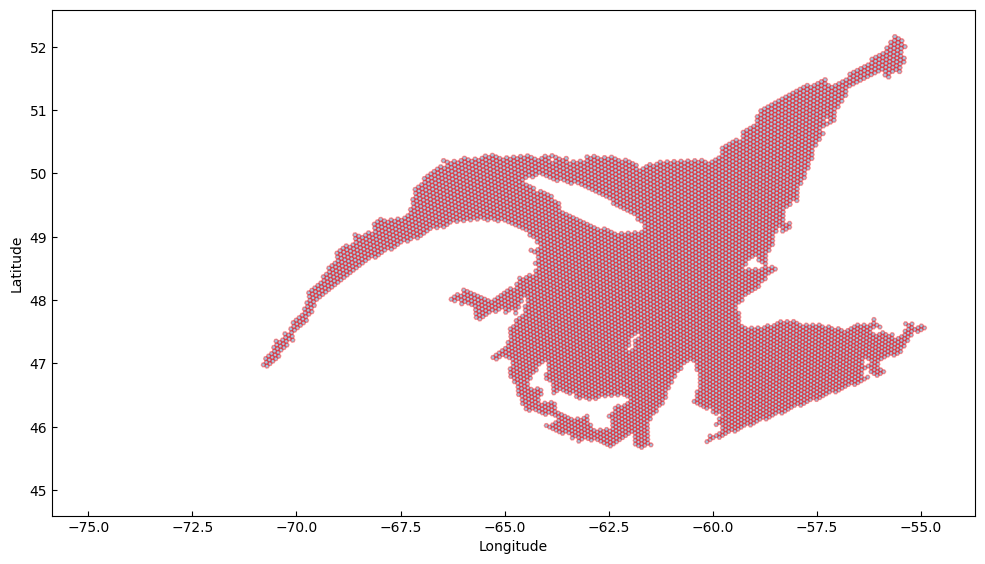

In [12]:
gdf_gulf = gpd.read_file(shapefile_path).to_crs(epsg=4326) # Input shapefile

# Plot the resulting shapefile
fig, ax = plt.subplots(figsize=(10, 10))
gdf_gulf.plot(ax=ax, color='white', alpha=1)
gdf_discretized.plot(ax=ax, edgecolor='red', alpha=.4)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(True)
plt.xlabel(r'Longitude')
plt.ylabel(r'Latitude')
plt.tight_layout()
ax.tick_params(axis='x', direction='in', bottom=True)
ax.tick_params(axis='y', direction='in', left=True)
plt.savefig('images/hexagon_full.pdf', format='pdf', bbox_inches='tight')
plt.savefig('images/hexagon_full.svg', format='svg', bbox_inches='tight')
plt.show()

# Using Tracks for Discretization

In [19]:
tracks = aisdb.track_gen.TrackGen(rowgen, decimate=True)
tracks_segment = aisdb.track_gen.split_timedelta(tracks,
                                                     timedelta(weeks=4))
tracks_with_indexes = descritizer.yield_tracks_discretized_by_indexes(tracks)

In [20]:
tracks_copy1,tracks_copy2,tracks_copy3,tracks_copy4 = itertools.tee(tracks_with_indexes, 4)

for track in tracks_copy1:
    print(f"H3 Index for lat {track['lat'][0]}, lon {track['lon'][0]}: {track['h3_index'][0]}")
    break

H3 Index for lat 50.003334045410156, lon -66.76000213623047: 860e4d31fffffff


# Vizualization for Discretization

## Discretization without using a shapefile

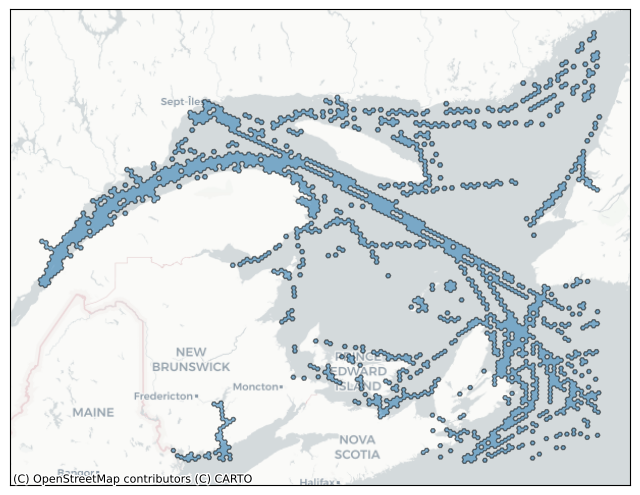

In [21]:
descritizer.plot_discretized_tracks(tracks = tracks_copy4 ,ax=None) # shapefile_path is optional

## Discretization using the pre-processed shapefile

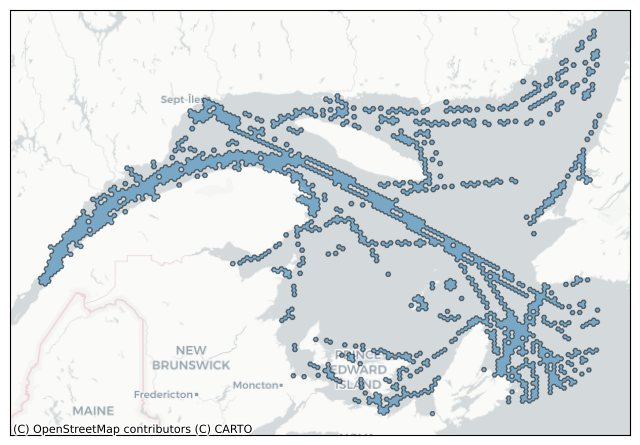

In [22]:
descritizer.plot_discretized_tracks(tracks = tracks_copy2, shapefile_path = 'outputs/new_filtered_hexagons.shp',ax=None) # shapefile_path is optional

# Extending the usage of discretization vizualization

In [23]:
# Color Tracks function (assigns colors)
def color_tracks2(tracks):
    colors = {}
    for track in tracks:
        mmsi = track.get('mmsi')
        if mmsi not in colors:
            # Assign a random color to this MMSI if not already assigned
            colors[mmsi] = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        track['color'] = colors[mmsi]  # Set the color for the current track
        yield track
        
def plot_tracks_with_hex_grids(tracks):
    tracks_copy1, tracks_copy2 = itertools.tee(tracks, 2)

    # Color the tracks
    colored_tracks = list(color_tracks2(tracks_copy1))

    # Convert tracks to GeoDataFrame for CRS transformation
    track_data = []
    min_lon, max_lon = float('inf'), float('-inf')
    min_lat, max_lat = float('inf'), float('-inf')

    for track in colored_tracks:
        # Update the bounding box
        min_lon = min(min_lon, *track['lon'])
        max_lon = max(max_lon, *track['lon'])
        min_lat = min(min_lat, *track['lat'])
        max_lat = max(max_lat, *track['lat'])

        # Creating a GeoDataFrame directly with the correct geometry
        geometry = gpd.GeoSeries(gpd.points_from_xy(track['lon'], track['lat']))
        gdf = gpd.GeoDataFrame({
            'mmsi': [track['mmsi']] * len(track['lat']),
            'geometry': geometry
        }, crs='EPSG:4326')
        track_data.append(gdf)

    # Merge all track GeoDataFrames and reproject to EPSG:3857 (Web Mercator)
    gdf_tracks = pd.concat(track_data, ignore_index=True)
    gdf_tracks = gdf_tracks.to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot vessel tracks with different colors
    for track in colored_tracks:
        # Transform coordinates to EPSG:3857 for each track
        transformed_coords = gpd.GeoSeries(gpd.points_from_xy(track['lon'], track['lat'])).set_crs('EPSG:4326').to_crs(epsg=3857)
        
        # Plot the entire track as a line (not individual points)
        ax.plot(transformed_coords.x, transformed_coords.y, color=track['color'], linewidth=2)

    # Plot hex grids (discretized tracks)
    descritizer.plot_discretized_tracks(tracks=tracks_copy2,shapefile_path = 'outputs/new_filtered_hexagons.shp', ax=ax)

    # Add CartoDB basemap (EPSG:3857)
    cx.add_basemap(ax, crs='EPSG:3857', source=cx.providers.CartoDB.Positron)

    # Set the limits to zoom in on the tracks
    # Convert min/max lat/lon to EPSG:3857 for accurate plotting limits
    min_lon, min_lat = gpd.GeoSeries(gpd.points_from_xy([min_lon], [min_lat])).set_crs('EPSG:4326').to_crs(epsg=3857).total_bounds[:2]
    max_lon, max_lat = gpd.GeoSeries(gpd.points_from_xy([max_lon], [max_lat])).set_crs('EPSG:4326').to_crs(epsg=3857).total_bounds[:2]

    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)

    ax.legend(loc='upper right')
    ax.set_title('Vessel Tracks with Hex Grids and Interpolated Path')
    plt.show()

/tmp/ipykernel_3609677/2329022746.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


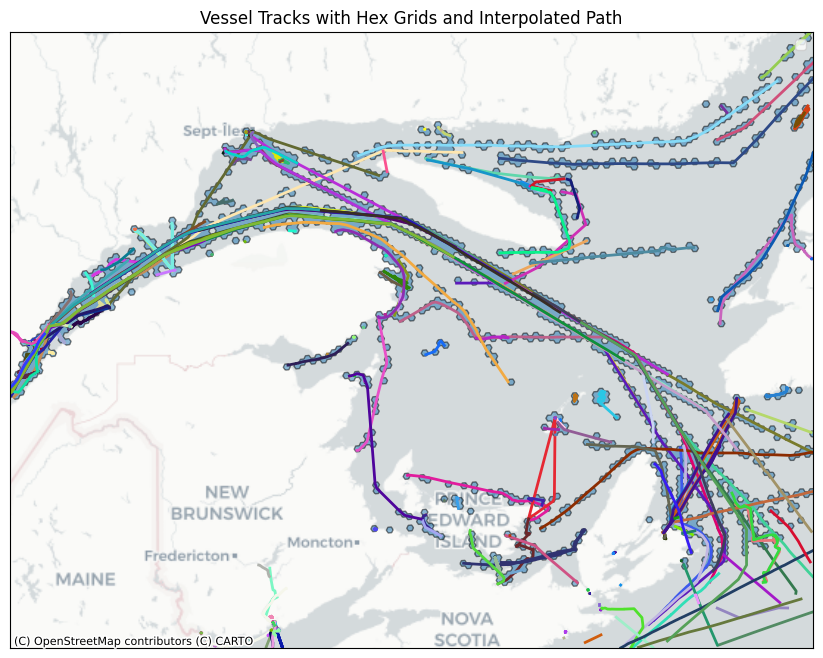

In [24]:
plot_tracks_with_hex_grids(tracks_copy3)